In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
with open ('LogiTrainedJpModel.pkl','rb') as file:
    model = pickle.load(file)

In [4]:
data2 = pd.read_excel("Copy of IN_Data.xlsx")
data2.head()

,ID,CURR_AGE,GENDER,ANN_INCOME,DT_MAINT
0,20710B05XL,54,M,1425390,2018-04-20
1,89602T51HX,47,M,1678954,2018-06-08
2,70190Z52IP,60,M,931624,2017-07-31
3,25623V15MU,55,F,1106320,2017-07-31
4,36230I68CE,32,F,748465,2019-01-27


In [6]:
data2['DT_MAINT'] = pd.to_datetime(data2['DT_MAINT'])
threshold_date = pd.to_datetime('2019-07-01')
data2['AGE_CAR'] = (threshold_date - data2['DT_MAINT']).dt.days
data2.head()

,ID,CURR_AGE,GENDER,ANN_INCOME,DT_MAINT,AGE_CAR
0,20710B05XL,54,M,1425390,2018-04-20,437
1,89602T51HX,47,M,1678954,2018-06-08,388
2,70190Z52IP,60,M,931624,2017-07-31,700
3,25623V15MU,55,F,1106320,2017-07-31,700
4,36230I68CE,32,F,748465,2019-01-27,155


In [7]:
data2['ANN_INCOME($)'] = data2['ANN_INCOME']*0.012 

In [8]:
def categorize_car_age(days):
        if days < 200:
            return 1
        elif 200 <= days <= 360:
            return 2
        elif 360 < days <= 500:
            return 3
        else:
            return 4
data2['AGE_CAR(Category)'] = data2['AGE_CAR'].apply(categorize_car_age)        

In [27]:
data2['GENDER(1,0)'] = data2['GENDER'].apply(lambda x: 1 if x == 1 else 0)

In [28]:
data2.head()

,ID,CURR_AGE,GENDER,ANN_INCOME,DT_MAINT,AGE_CAR,ANN_INCOME($),AGE_CAR(Category),"GENDER(1,0)"
0,20710B05XL,54,1,1425390,2018-04-20,437,17104.680,3,1
1,89602T51HX,47,1,1678954,2018-06-08,388,20147.448,3,1
2,70190Z52IP,60,1,931624,2017-07-31,700,11179.488,4,1
3,25623V15MU,55,0,1106320,2017-07-31,700,13275.840,4,0
4,36230I68CE,32,0,748465,2019-01-27,155,8981.580,1,0


In [29]:
X = data2.drop(columns= ['ID','ANN_INCOME','DT_MAINT','AGE_CAR','GENDER'])
X.head(25)

,CURR_AGE,ANN_INCOME($),AGE_CAR(Category),"GENDER(1,0)"
0,54,17104.680,3,1
1,47,20147.448,3,1
2,60,11179.488,4,1
3,55,13275.840,4,0
4,32,8981.580,1,0
5,48,12623.124,2,0
6,26,12916.824,2,0
7,45,17783.388,3,0
8,55,20707.284,4,1
9,64,3747.876,3,0


In [31]:
pred = model.predict(X)
predProbab = model.predict_proba(X)[:,1]

potentialCustomer = sum(pred)
purchaseRate = (potentialCustomer/len(X))*100
print(f"Potential Indian Customers: {potentialCustomer}")
print(f"Purchase Rate: {purchaseRate}")


Potential Indian Customers: 69400
Purchase Rate: 99.14285714285714


In [34]:
indian_results = pd.DataFrame({
    'ID': data2['ID'],
    'Purchase_Probability': predProbab,
    'Predicted_Purchase': pred,
    'Age': data2['CURR_AGE'],
    'Income': data2['ANN_INCOME']
})

indian_results['Probability_Segment'] = pd.qcut(
    indian_results['Purchase_Probability'], 
    q=4, 
    labels=['Low', 'Medium', 'High', 'Very High']
)

print("\nCustomer Segment Analysis:")
print(indian_results.groupby('Probability_Segment').agg({
    'ID': 'count',
    'Purchase_Probability': ['mean', 'min', 'max'],
    'Age': 'mean',
    'Income': 'mean'
}).round(3))



Customer Segment Analysis:
                        ID Purchase_Probability                   Age  \
                     count                 mean    min    max    mean   
Probability_Segment                                                     
Low                  17500                0.853  0.314  0.959  45.589   
Medium               17500                0.979  0.959  0.990  42.485   
High                 17500                0.995  0.990  0.998  43.931   
Very High            17500                0.999  0.998  1.000  47.977   

                          Income  
                            mean  
Probability_Segment               
Low                   719637.476  
Medium               1010855.153  
High                 1251592.815  
Very High            1612628.634  


C:\Users\Vaibhav\AppData\Local\Temp\ipykernel_5864\672760172.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(indian_results.groupby('Probability_Segment').agg({


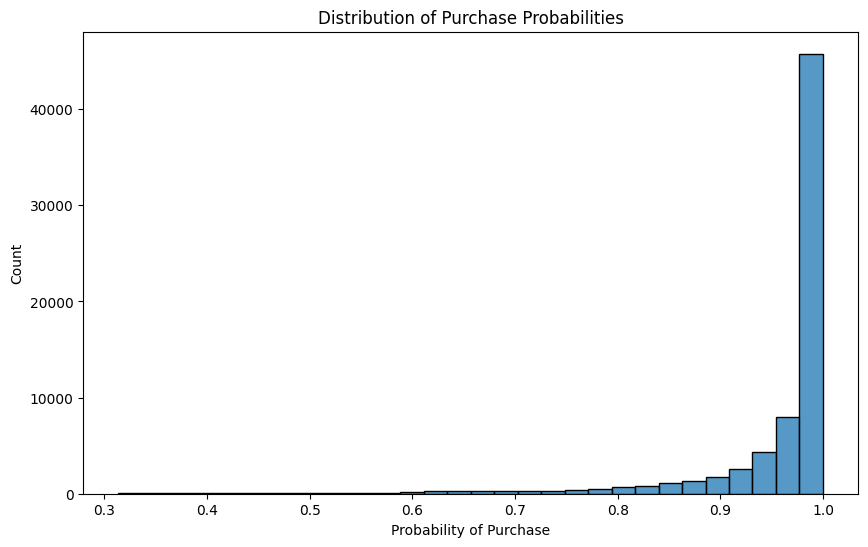

In [36]:
plt.figure(figsize=(10, 6))
sns.histplot(indian_results['Purchase_Probability'], bins=30)
plt.title('Distribution of Purchase Probabilities')
plt.xlabel('Probability of Purchase')
plt.ylabel('Count')
plt.show()

In [37]:
# Compare with target
target_sales = 12000
predicted_sales = potentialCustomer

print("\nSales Target Analysis:")
print(f"Target Sales: {target_sales}")
print(f"Predicted Sales: {predicted_sales}")
print(f"Difference: {predicted_sales - target_sales}")
print(f"Achievement Rate: {(predicted_sales/target_sales)*100:.2f}%")

# Profile of likely buyers
likely_buyers = indian_results[indian_results['Predicted_Purchase'] == 1]
print("\nLikely Buyers Profile:")
print(likely_buyers.describe())


Sales Target Analysis:
Target Sales: 12000
Predicted Sales: 69400
Difference: 57400
Achievement Rate: 578.33%

Likely Buyers Profile:
       Purchase_Probability  Predicted_Purchase           Age        Income
count          69400.000000             69400.0  69400.000000  6.940000e+04
mean               0.961017                 1.0     44.878732  1.155406e+06
std                0.072119                 0.0     11.799386  3.945158e+05
min                0.500228                 1.0     25.000000  3.000330e+05
25%                0.960753                 1.0     35.000000  8.641398e+05
50%                0.990314                 1.0     45.000000  1.129560e+06
75%                0.997817                 1.0     55.000000  1.441504e+06
max                0.999962                 1.0     65.000000  1.999989e+06
